In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import time

from PIL import Image
from sklearn.metrics import confusion_matrix,classification_report

from keras.layers import Dense, ConvLSTM2D, Dropout, Flatten
from keras.utils import to_categorical
from keras import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam, RMSprop

import tensorflow as tf

In [2]:
fps = '2FPS'
numpy_dir = '../../data/DAiSEE/' + fps + '/data/' 
usage = ['Train', 'Test', 'Validation']
model_dir = '../../data/models/convLSTM/'

In [3]:
# Get image files
x_train = np.load(numpy_dir + 'X_train_img.npy', allow_pickle=True) 
x_val = np.load(numpy_dir + 'X_val_img.npy', allow_pickle=True) 

# Get y labels
y_train = np.load(numpy_dir + 'y_cat_train.npy', allow_pickle=True) 
y_val = np.load(numpy_dir + 'y_cat_val.npy', allow_pickle=True) 

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(107160, 160, 160, 3) (107160, 4)
(28580, 160, 160, 3) (28580, 4)


In [4]:
# Reshape to get sequences together
x_train = x_train.reshape(int(x_train.shape[0]/20), 20, 160, 160, 3)
x_val = x_val.reshape(int(x_val.shape[0]/20), 20, 160, 160, 3)

y_train = y_train[1::20]
y_val = y_val[1::20]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(5358, 20, 160, 160, 3) (5358, 4)
(1429, 20, 160, 160, 3) (1429, 4)


In [5]:
# Setup the GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=16000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


In [6]:
#################
# CNN-LSTM.     # 
#################

lr = 0.0001
decay = 1e-6

img_height , img_width = 160, 160
seq_len = 20
  
model = Sequential()
model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), return_sequences = False, data_format = "channels_last", input_shape = (seq_len, img_height, img_width, 3)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(4, activation = "softmax"))
 
model.summary()

# checkpoint callback
timestr = time.strftime("%Y%m%d-%H%M%S")
best_model_file = model_dir + 'ConvLSTM2D' + timestr + '_{epoch}.hdf5'
checkpoint = ModelCheckpoint(best_model_file,
                             monitor='accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

# early stopping callback
#early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')   
early_stopping = EarlyStopping(monitor='accuracy', patience=4, verbose=1, mode='auto') 

callbacks = [checkpoint, early_stopping]

model.compile(optimizer=Adam(lr=lr, decay=decay),
              loss="categorical_crossentropy",
              metrics =["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 158, 158, 16)      11008     
_________________________________________________________________
dropout (Dropout)            (None, 158, 158, 16)      0         
_________________________________________________________________
flatten (Flatten)            (None, 399424)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               102252800 
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 102,264,836
Trainable params: 102,264,836
Non-trainable params: 0
__________________________________________

In [7]:
history = model.fit(
    x=x_train, 
    y=y_train, 
    batch_size=16, 
    epochs=100, 
    verbose=1, 
    callbacks=callbacks,
    validation_data=(x_val, y_val), 
)

Epoch 1/100
335/335 [==============================] - ETA: 0s - loss: 1.7156 - accuracy: 0.4188
Epoch 00001: accuracy improved from -inf to 0.41881, saving model to ../../data/models/convLSTM/ConvLSTM2D20201205-112215_1.hdf5
335/335 [==============================] - 105s 314ms/step - loss: 1.7156 - accuracy: 0.4188 - val_loss: 1.3587 - val_accuracy: 0.3121
Epoch 2/100
335/335 [==============================] - ETA: 0s - loss: 1.1414 - accuracy: 0.4343
Epoch 00002: accuracy improved from 0.41881 to 0.43430, saving model to ../../data/models/convLSTM/ConvLSTM2D20201205-112215_2.hdf5
335/335 [==============================] - 103s 309ms/step - loss: 1.1414 - accuracy: 0.4343 - val_loss: 1.3195 - val_accuracy: 0.2547
Epoch 3/100
335/335 [==============================] - ETA: 0s - loss: 1.0978 - accuracy: 0.4420
Epoch 00003: accuracy improved from 0.43430 to 0.44196, saving model to ../../data/models/convLSTM/ConvLSTM2D20201205-112215_3.hdf5
335/335 [==============================] - 103

335/335 [==============================] - 103s 309ms/step - loss: 0.3917 - accuracy: 0.8343 - val_loss: 3.6537 - val_accuracy: 0.3191
Epoch 24/100
335/335 [==============================] - ETA: 0s - loss: 0.3805 - accuracy: 0.8320
Epoch 00024: accuracy did not improve from 0.83427
335/335 [==============================] - 101s 300ms/step - loss: 0.3805 - accuracy: 0.8320 - val_loss: 3.8299 - val_accuracy: 0.3177
Epoch 25/100
335/335 [==============================] - ETA: 0s - loss: 0.3474 - accuracy: 0.8527
Epoch 00025: accuracy improved from 0.83427 to 0.85274, saving model to ../../data/models/convLSTM/ConvLSTM2D20201205-112215_25.hdf5
335/335 [==============================] - 103s 309ms/step - loss: 0.3474 - accuracy: 0.8527 - val_loss: 3.7443 - val_accuracy: 0.3163
Epoch 26/100
335/335 [==============================] - ETA: 0s - loss: 0.3393 - accuracy: 0.8550
Epoch 00026: accuracy improved from 0.85274 to 0.85498, saving model to ../../data/models/convLSTM/ConvLSTM2D20201205

Epoch 48/100
335/335 [==============================] - ETA: 0s - loss: 0.1575 - accuracy: 0.9321
Epoch 00048: accuracy improved from 0.93188 to 0.93206, saving model to ../../data/models/convLSTM/ConvLSTM2D20201205-112215_48.hdf5
335/335 [==============================] - 103s 308ms/step - loss: 0.1575 - accuracy: 0.9321 - val_loss: 4.1793 - val_accuracy: 0.3373
Epoch 49/100
335/335 [==============================] - ETA: 0s - loss: 0.1369 - accuracy: 0.9395
Epoch 00049: accuracy improved from 0.93206 to 0.93953, saving model to ../../data/models/convLSTM/ConvLSTM2D20201205-112215_49.hdf5
335/335 [==============================] - 104s 309ms/step - loss: 0.1369 - accuracy: 0.9395 - val_loss: 4.4284 - val_accuracy: 0.3219
Epoch 50/100
335/335 [==============================] - ETA: 0s - loss: 0.1461 - accuracy: 0.9349
Epoch 00050: accuracy did not improve from 0.93953
335/335 [==============================] - 101s 302ms/step - loss: 0.1461 - accuracy: 0.9349 - val_loss: 4.6908 - val_a

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


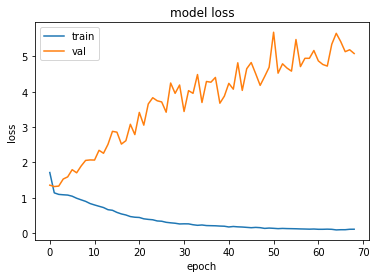

In [9]:
# Show graphs
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


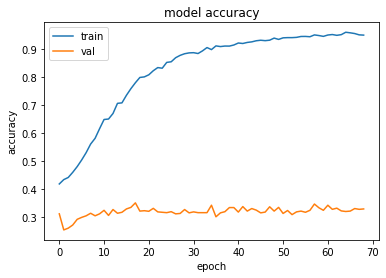

In [10]:
print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# test Data

In [27]:
# Get image files
x_test = np.load(numpy_dir + 'X_test_img.npy', allow_pickle=True) 
y_test = np.load(numpy_dir + 'y_cat_test.npy', allow_pickle=True)  
print(x_test.shape, y_test.shape)

(35680, 160, 160, 3) (35680, 4)


In [28]:
# Reshape to get sequences together
x_test = x_test.reshape(int(x_test.shape[0]/20), 20, 160, 160, 3)
y_test = y_test[1::20]
print(x_test.shape, y_test.shape)

(1784, 20, 160, 160, 3) (1784, 4)


In [29]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('test acc:', test_acc)

56/56 [==============================] - 9s 157ms/step - loss: 2.9969 - accuracy: 0.3436
test acc: 0.34360986948013306


In [30]:
# test on unseen data
y_pred = model.predict(x_test)

In [31]:
# to get around one hot encoding
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

In [32]:
# print the report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.45      0.38      0.41       823
          1       0.33      0.47      0.39       584
          2       0.16      0.09      0.11       338
          3       0.00      0.00      0.00        39

avg / total       0.35      0.34      0.34      1784



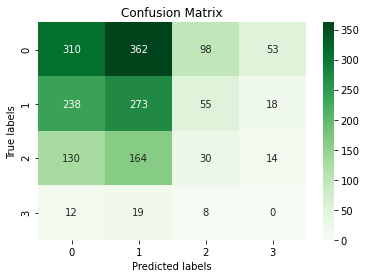

In [33]:
class_labels = [0,1,2,3]
cm = confusion_matrix(y_test, y_pred, class_labels)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Greens'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(class_labels); ax.yaxis.set_ticklabels(class_labels);